# Advanced Lane Finding Project

## The goals / steps of this project

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration

I used the OpenCV functions cv2.findChessboardCorners() and cv2.drawChessboardCorners() to automatically find and draw corners in an image of a chessboard pattern.
Below are the example images.

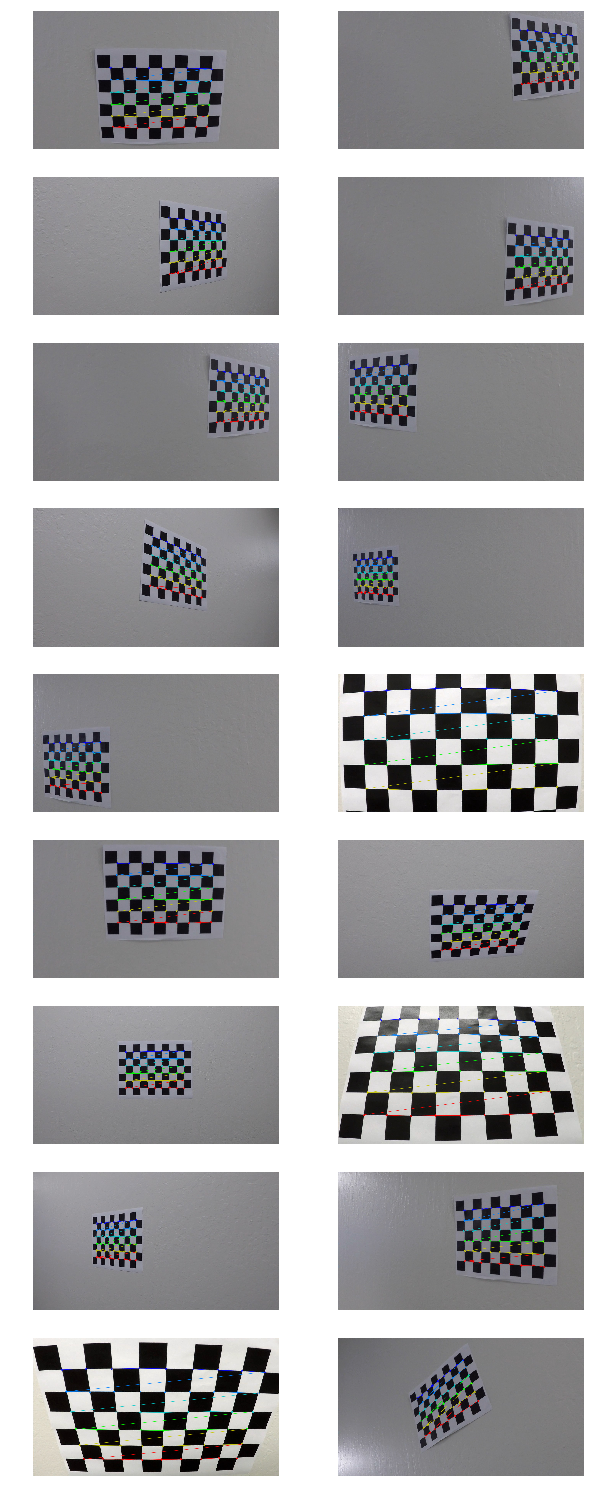

In [2]:
# Read in a calibration image
images = glob.glob('./camera_cal/*.jpg')

# Array to store object points and image points from all the images
objpoints = [] # 3D point in real world space
imgpoints = [] # 2D points in image plane

total_image_count = len(images)
image_count = 1
fig = plt.figure()
fig.set_size_inches(10,30)
for fname in images:
    # Read in each image
    img = mpimg.imread(fname)

    nx, ny = 6, 9
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1, 2)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (ny, nx), None)

    if ret == False:
        nx, ny = 5, 9
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1, 2)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (ny, nx), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (ny, nx), corners, ret)
        ax = fig.add_subplot(math.ceil(total_image_count / 2), 2, image_count)
        ax.imshow(img)
        ax.axis('off')
        image_count += 1

I undistorted the image with object points and image points by using the results of camera calibration.

cv2.calibrateCamera() function takes object points, image points, the height and width of image and returns camera matrix, distortion correction, rotation and translation vectors.
cv2.undistort() function takes original distorted image, camera matrix, distortion correction and returns undistorted image.

Below are the example images.

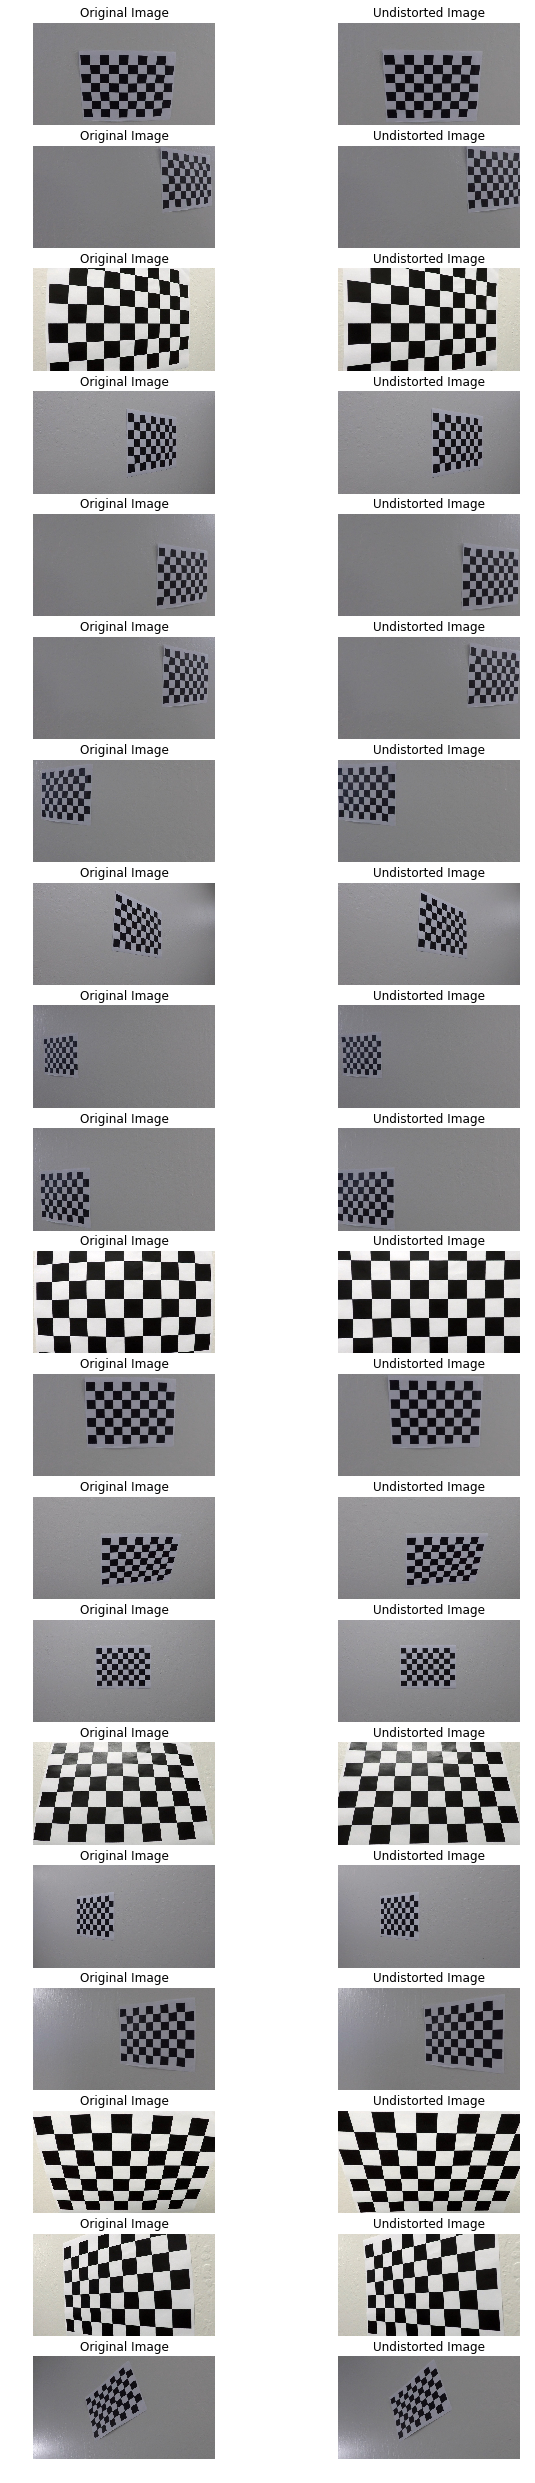

In [3]:
# Function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and returns the undistorted image
def undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

total_image_count = len(images)
image_count = 1
fig = plt.figure()
fig.set_size_inches(10,90)

for fname in images:
    img = mpimg.imread(fname)
    undistorted = undistort(img, objpoints, imgpoints)
    
    ax = fig.add_subplot(total_image_count * 2, 2, image_count)
    ax.imshow(img)
    ax.set_title('Original Image')
    ax.axis('off')
    image_count += 1
    
    ax = fig.add_subplot(total_image_count * 2, 2, image_count)
    ax.imshow(undistorted)
    ax.set_title('Undistorted Image')
    ax.axis('off')
    image_count += 1

# Pipeline (single images)

## 1. Distortion correction

I applied my undistort() function to the check if it works fine with images other than chessboard pattern.
Below are the sample images.

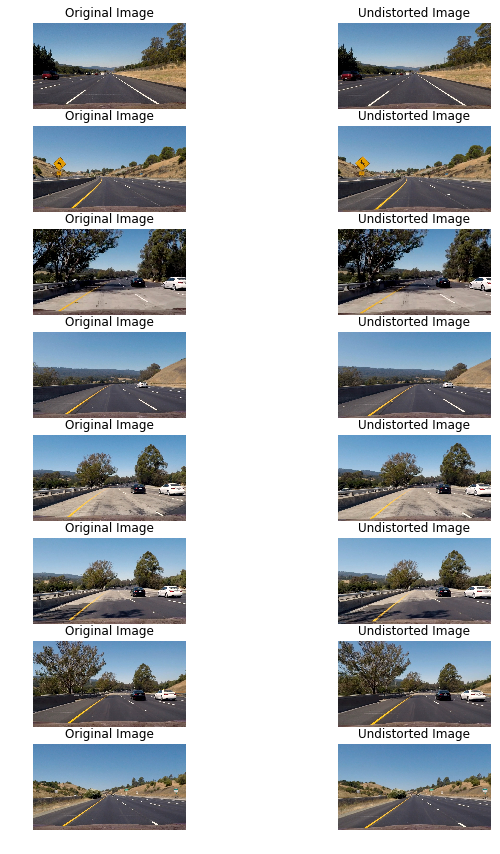

In [4]:
test_images = glob.glob('./test_images/*.jpg')

total_image_count = len(test_images)
image_count = 1
fig = plt.figure()
fig.set_size_inches(10,30)

for fname in test_images:
    img = mpimg.imread(fname)
    undistorted = undistort(img, objpoints, imgpoints)
    
    ax = fig.add_subplot(total_image_count * 2, 2, image_count)
    ax.imshow(img)
    ax.set_title('Original Image')
    ax.axis('off')
    image_count += 1
    
    ax = fig.add_subplot(total_image_count * 2, 2, image_count)
    ax.imshow(undistorted)
    ax.set_title('Undistorted Image')
    ax.axis('off')
    image_count += 1

## 2. Color/gradient threshold

I defined several threshold methods and applied them to one of undistorted images.

abs_sobel_thresh() is a function, which applies Sobel x or y, takes an absolute value, then applies a threshold.
mag_thresh() is a function, which applies Sobel x and y, computes the magnitude of the gradient, then applies a threshold.
dir_thresh() is a function, which applies Sobel x and y, computes the direction of the gradient, then applies a threshold.
color_threshold() is a function, which applies Sobel x and y, computes the magnitude of the gradient, then applies a threshold color channel.
threshold() is a function, which threshholds image on saturation channel and uses magnitude gradient.

Below are the sample images.

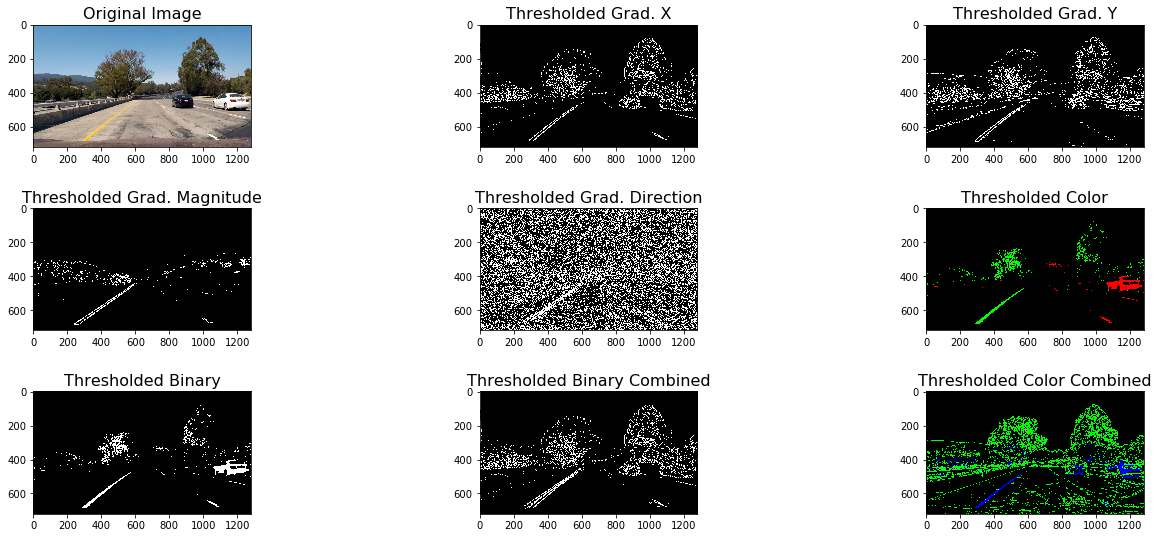

In [5]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(hls[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(hls[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient and applies a threshold
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient and applies a threshold.
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# computes the threshold x and y gradient and threshold color channel,
# then applies a threshold.
def color_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
#    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
#    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
#    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(gradmag)
    sxbinary[(gradmag >= sx_thresh[0]) & (gradmag <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

def threshold(img, color=False, mag_dir_thresh=False):
    """Threshhold image on saturation channel and using magnitude gradient"""
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    ## White Color
    lower_white = np.array([0,210,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    
    ## Yellow Color
    lower_yellow = np.array([18,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)  
    
    combined_binary = np.zeros_like(white_mask)
    
    # Dir Mag Threshold
    if mag_dir_thresh:
        dir_mask = dir_threshold(img)
        mag_mask = mag_thresh(img)
        combined_binary[((dir_mask == 1) & (mag_mask == 1))] = 255
        
    if color:
        return np.dstack((white_mask, yellow_mask, combined_binary))
    
    else:
        combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 255
        combined_binary[(combined_binary == 255)] = 1
        return combined_binary

test_image = plt.imread('./test_images/test1.jpg')
undistorted_image = undistort(test_image, objpoints, imgpoints)    

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(test_image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(test_image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(test_image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(test_image, sobel_kernel=ksize, thresh=(0.7, 1.3))
color_binary = color_threshold(test_image)

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

thresholded = threshold(test_image, color=True)
b_thresholded = threshold(test_image)

# Plot the result
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(24, 9))
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.5)
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Thresholded Grad. X', fontsize=16)
ax3.imshow(grady, cmap='gray')
ax3.set_title('Thresholded Grad. Y', fontsize=16)
ax4.imshow(mag_binary, cmap='gray')
ax4.set_title('Thresholded Grad. Magnitude', fontsize=16)
ax5.imshow(dir_binary, cmap='gray')
ax5.set_title('Thresholded Grad. Direction', fontsize=16)
ax6.imshow(thresholded)
ax6.set_title('Thresholded Color', fontsize=16)
ax7.imshow(b_thresholded, cmap='gray')
ax7.set_title('Thresholded Binary', fontsize=16)
ax8.imshow(combined, cmap='gray')
ax8.set_title('Thresholded Binary Combined', fontsize=16)
ax9.imshow(color_binary)
ax9.set_title('Thresholded Color Combined', fontsize=16)

## 3. Perspective transform

I used the below source (src) and destination (dst) points for perspective transform.

In [6]:
img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
width, height = img_size

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

print('src =', src)
print('dst =', dst)

src = [[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           460.        ]]
dst = [[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


I verified that my perspective transform was working as expected by drawing the src and dst points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

cv2.getPerspectiveTranform(src,dst) is a function to get a transform matrix.
cv2.getPerspectiveTranform(dst,src) is a inverse of the above.

Below is the sample image.

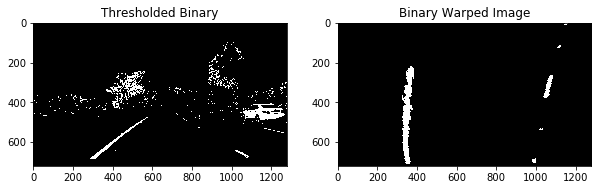

In [7]:
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
b_thresholded = threshold(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')

plt.subplot(1,2,2)
binary_warped = cv2.warpPerspective(b_thresholded, M, (width, height))
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')

## 4. Detect lane lines

To decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line, I first took a histogram along all the columns in the lower half of the image as follow.

/home/psyto/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


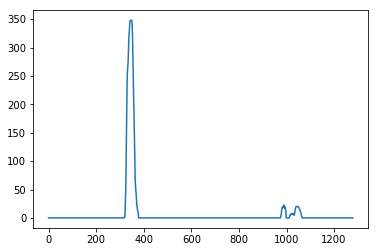

In [8]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

For Sliding Windows and Fit a Polynomial, I used the below sample code from 33. Finding the Lanes.

In [9]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

I visualized the result as follows.

(720, 0)

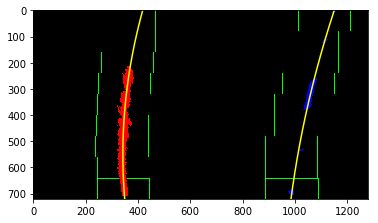

In [10]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

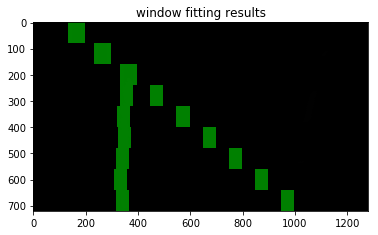

In [11]:
# Read in a thresholded image
warped = binary_warped
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## 5. Determine the lane curvature

I calculated the curvature as follows.

In [12]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = 700
midx = 650

y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Radius of Curvature: %f" % curvature)

Radius of Curvature: 658.690006


I plotted the calculated curvature onto the undistorted image.

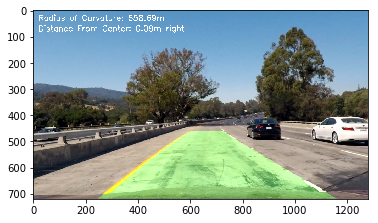

In [13]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)

cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
if position_from_center < 0:
    text = 'left'
else:
    text = 'right'
cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
plt.imshow(result)

# Pipeline (video)

I created the below pipeline function by combining the functions (Sliding Window, Fit a Polynominal, Sliding Window Search, and Caliculate a curvature) explained in Pipeline (single images) section.

In [14]:
def pipeline(img):
    
    test_image = img

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(test_image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(test_image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(test_image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(test_image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    color_binary = color_threshold(test_image)

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    thresholded = threshold(test_image, color=True)
    b_thresholded = threshold(test_image)
    
    img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
    width, height = img_size

    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    b_thresholded = threshold(test_image)
    binary_warped = cv2.warpPerspective(b_thresholded, M, (width, height))
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)    
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Read in a thresholded image
    warped = binary_warped
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 700
    midx = 650

    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    return result

I re-used the video processing function, which I developed in P1 Finding Lane Lines project, and passed pipeline function to VideoFileClip.fl_image() function.

In [15]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [14:37<00:00,  1.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 49min 13s, sys: 2min 7s, total: 51min 20s
Wall time: 14min 39s


# Discussion

In the code above, perspective transform totally depends on the selection of source (src) and destination (dst) points.
I found that even slight change in source and destination points will make lane lines undetected in binary warped image.
If camera position or angle is changed by something during driving (for example, flying bird hits camera), we need to update the camera calibration as fast as possible.
We need to care this point when we use this method in real autonomous driving.

I found that my pipeline does not work well with harder_challenge_video.mp4.
harder_challenge_video.mp4 has dirty front glass, frequent curve, and many cars and bicycles.
I felt that they affected a lot on the calculation of threshold.
We need to take care this point as these situations are common in real autonomous driving.

I think there may be many ways to improve pipeline method, but it will make pipeline method complicated (it is already complicated).
I felft that deep learning is more simple and robust than this approach.